## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

## Create a dataset

In [2]:
os.chdir('../')
os.chdir('data')
os.chdir('train')

In [3]:
data_dir = os.getcwd()

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5470 files belonging to 37 classes.
Using 4376 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5470 files belonging to 37 classes.
Using 1094 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
print(class_names)

['Adenoviridae', 'Alphacoronavirus', 'Alphacoronavirus1', 'Anelloviridae', 'Betacoronavirus', 'Betaflexiviridae', 'Bromoviridae', 'Calciviridae', 'Caudovirales', 'Coronaviridae', 'Deltacoronavirus', 'Deltacoronavirus3', 'Embecovirus', 'Embecovirus1', 'Flaviviridae', 'Gammacoronavirus', 'Geminiviridae', 'Genomoviridae', 'Merbecovirus', 'Merbecovirus1', 'Microviridae', 'Nobecovirus', 'Nobecovirus1', 'Ortervirales', 'Papillomaviridae', 'Parvoviridae', 'Peribunyaviridae', 'Phenuiviridae', 'Picornaviridae', 'Polydnaviridae', 'Polyomaviridae', 'Potyviridae', 'Reoviridae', 'Rhabdoviridae', 'Riboviria', 'Sarbecovirus', 'Secoviridae']


## Visualize the data

Here are the first 9 images from the training dataset.

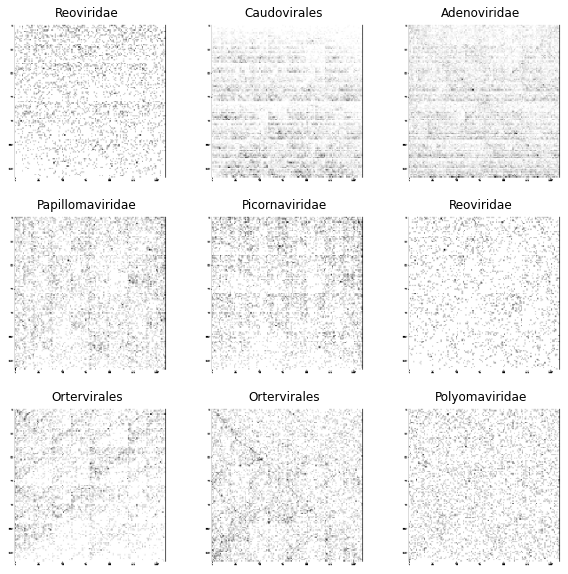

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
137/137 [==============================] - 133s 957ms/step - loss: 3.6055 - accuracy: 0.0849 - val_loss: 3.2210 - val_accuracy: 0.0750
Epoch 2/15
137/137 [==============================] - 118s 864ms/step - loss: 3.2079 - accuracy: 0.1042 - val_loss: 2.4900 - val_accuracy: 0.3090
Epoch 3/15
137/137 [==============================] - 116s 848ms/step - loss: 1.9526 - accuracy: 0.4811 - val_loss: 0.9705 - val_accuracy: 0.7285
Epoch 4/15
137/137 [==============================] - 121s 885ms/step - loss: 0.9386 - accuracy: 0.7333 - val_loss: 0.7919 - val_accuracy: 0.7367
Epoch 5/15
137/137 [==============================] - 113s 822ms/step - loss: 0.6985 - accuracy: 0.7805 - val_loss: 0.6660 - val_accuracy: 0.7706
Epoch 6/15
137/137 [==============================] - 110s 804ms/step - loss: 0.5410 - accuracy: 0.8045 - val_loss: 0.6107 - val_accuracy: 0.7907
Epoch 7/15
137/137 [==============================] - 108s 788ms/step - loss: 0.4711 - accuracy: 0.8266 - val_loss: 0.5810 -

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
image_path = os.getcwd()+'/Bromoviridae/NC_0020251 Alfalfa mosaic virus RNA 3 complete sequence.png'

In [ ]:
img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)